# Задание:

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH


# Violence Detection using CNN + LSTM neural netowrk

## Introduction

Today, the amount of public violence has increased dramatically. As much in high schools as in the street. This has resulted in the ubiquitous use of surveillance cameras. This has helped the authorities to identify these events and take the necessary measures. But almost all systems today require the human-inspection of these videos to identify such events, which is virtually inefficient. It is therefore necessary to have such a practical system that can automatically monitor and identify the surveillance videos.
The development of various deep learning techniques, thanks to the availability of large data sets and computational resources, has resulted in a historic change in the community of computer vision. Various techniques have been developed to address problems such as object detection, recognition, tracking, action recognition, legend generation, etc. However, despite recent developments in deep learning, very few techniques based on deep learning have been proposed to address the problem of detecting violence from videos.

## Flowchart

The method consists of extracting a set of frames belonging to the video, sending them to a pretrained network called VGG16, obtaining the output of one of its final layers and from these outputs train another network architecture with a type of special neurons called LSTM. These neurons have memory and are able to analyze the temporal information of the video, if at any time they detect violence, it will be classified as a violent video.





## Imports

In [106]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py
import glob

In [2]:
keras.__version__

'2.8.0'

In [3]:
#скачиваем архивы с датасетами
!wget http://www.csc.kth.se/cvap/actions/walking.zip
!wget http://www.csc.kth.se/cvap/actions/jogging.zip
!wget http://www.csc.kth.se/cvap/actions/running.zip
!wget http://www.csc.kth.se/cvap/actions/boxing.zip
!wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!wget http://www.csc.kth.se/cvap/actions/handclapping.zip

--2022-09-07 10:30:30--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-09-07 10:30:31--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   824KB/s    in 4m 42s  

2022-09-07 10:35:13 (840 KB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-09-07 10:35:13--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29

In [4]:
#распаковываем архивы
!unzip walking.zip -d walking > /dev/null
!unzip jogging.zip -d jogging > /dev/null
!unzip running.zip -d running > /dev/null
!unzip boxing.zip -d boxing > /dev/null
!unzip handwaving.zip -d handwaving > /dev/null
!unzip handclapping.zip -d handclapping > /dev/null

In [5]:
#удаляем архивы (чтобы освободить место на диске)
!rm walking.zip
!rm jogging.zip
!rm running.zip
!rm boxing.zip
!rm handwaving.zip
!rm handclapping.zip

In [74]:
#список классов
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

In [75]:
#составляем список (путь к видео, класс)

# Для обучения будем использовать весь набор данных, а не часть
dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
      dataset.append((fpath, cls)) #(путь, класс)
print(f'Количество объектов: {len(dataset)}')

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping
Количество объектов: 599


## Helper Functions

We will use the function ```print_progress``` to print the amount of videos processed the datasets

In [76]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

## Load Data

Firstly, we define the directory to place the video dataset

In [77]:
in_dir = []
for cls in classes:
    in_dir_i = f"/content/{cls}"
    in_dir.append(in_dir_i)
in_dir

['/content/walking',
 '/content/jogging',
 '/content/running',
 '/content/boxing',
 '/content/handwaving',
 '/content/handclapping']

Copy some of the data-dimensions for convenience.

In [78]:
# Frame size  
#img_size = 224

img_size_touple = (224, 224)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = 224 * 224 * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 6

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 150

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

### Helper-function for getting video frames
Function used to get 150 frames from a video file and convert the frame to a suitable format for the neural net.

In [79]:
#from pyparsing import results
def get_frames(file_path):
    
    #in_file = os.path.join(current_dir, dir_name, file_name)
    #in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(file_path)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=img_size_touple,
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

### Helper function to get the names of the data downloaded and label it

In [80]:
def label_video_names(in_dir):
    
    # list containing video names
    file_paths = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []

    for in_dir_i in in_dir:
        for current_dir, dir_names, file_names in os.walk(in_dir_i):

            #print(current_dir[9:])
        
            for file_name in file_names:
                if current_dir[9:] == 'walking':
                    labels.append([1,0,0,0,0,0])
                if current_dir[9:] == 'jogging':
                    labels.append([0,1,0,0,0,0])
                if current_dir[9:] == 'running':
                    labels.append([0,0,1,0,0,0])
                if current_dir[9:] == 'boxing':
                    labels.append([0,0,0,1,0,0])
                if current_dir[9:] == 'handwaving':
                    labels.append([0,0,0,0,1,0])
                if current_dir[9:] == 'handclapping':
                    labels.append([0,0,0,0,0,1])
                file_paths.append(current_dir+ '/' + file_name)
                #names.append(file_name)
                     
            
    c = list(zip(file_paths,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    #shuffle(file_paths)
    
    file_paths, labels = zip(*c)
            
    return file_paths, labels

### Plot a video frame to see if data is correct

In [81]:
# First get the names and labels of the whole videos
file_paths, labels = label_video_names(in_dir)

Then we are going to load 150 frames of one video, for example

In [82]:
file_paths[12]

'/content/handclapping/person24_handclapping_d1_uncomp.avi'

The video has violence, look at the name of the video, starts with 'fi'

In [83]:
frames = get_frames(file_paths[12])

Convert back the frames to uint8 pixel format to plot the frame

In [84]:
visible_frame = (frames*255).astype('uint8')

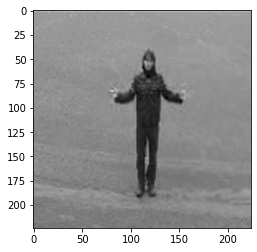

In [85]:
plt.imshow(visible_frame[3])

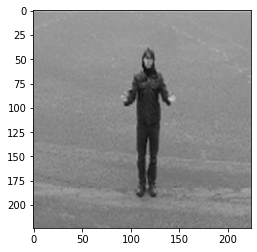

In [86]:
plt.imshow(visible_frame[15])

## Pre-Trained Model: Mobile NET

The following creates an instance of the pre-trained MobileNet model using the Keras API. This automatically downloads the required files if you don't have them already.

The MobileNet model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole MobileNet model is downloaded which is about 528 MB. If include_top=False then only the convolutional part of the MobileNet model is downloaded which is just 57 MB.

In [87]:
image_model = MobileNet( weights='imagenet',include_top=True,input_shape=(224,224,3))

Let's see the model summary

In [88]:
image_model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [89]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('reshape_2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the MobileNet net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of Mobilenet net have dimensions: ", transfer_values_size)

The input of the MobileNet net have dimensions: (224, 224)
The output of the selecter layer of Mobilenet net have dimensions:  1000


### Function to process 150 video frames through Mobilenet and get transfer values

In [90]:
def get_transfer_values(file_paths):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(file_paths)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

### Generator that process one video through Mobilenet each function call

In [91]:
def proces_transfer(file_paths, labels):
    
    count = 0
    
    tam = len(file_paths)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = file_paths[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([150,6])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

### Functions to save transfer values from Mobilenet to later use
We are going to define functions to get the transfer values from Mobilenet with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one. 

In [92]:
def make_files(n_files):
    
    gen = proces_transfer(file_paths_training, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [93]:
def make_files_test(n_files):
    
    gen = proces_transfer(file_paths_test, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

### Split the dataset into training set and test set
We are going to split the dataset into training set and testing. The training set is used to train the model and the test set to check the model accuracy.

In [94]:
training_set = int(len(file_paths)*0.8)
test_set = int(len(file_paths)*0.2)

file_paths_training = file_paths[0:training_set]
file_paths_test = file_paths[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

Then we are going to process all video frames through Mobilenet and save the transfer values.

In [95]:
make_files(training_set)

- Progress: 99.8%

In [96]:
make_files_test(test_set)

- Progress: 99.2%

### Load the cached transfer values into memory
We have already saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net. One question would be: why not process transfer values and load them into RAM memory? Yes is a more eficient way to train the second net. But if you have to train the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through Mobilenet net. 


In order to load the saved transfer values into RAM memory we are going to use this two functions:

In [97]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [98]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [99]:
data, target = process_alldata_training()

In [100]:
data_test, target_test = process_alldata_test()

##Recurrent Neural Network

The basic building block in a Recurrent Neural Network (RNN) is a Recurrent Unit (RU). There are many different variants of recurrent units such as the rather clunky LSTM (Long-Short-Term-Memory) and the somewhat simpler GRU (Gated Recurrent Unit) which we will use in this tutorial. Experiments in the literature suggest that the LSTM and GRU have roughly similar performance. Even simpler variants also exist and the literature suggests that they may perform even better than both LSTM and GRU, but they are not implemented in Keras which we will use in this tutorial.

A recurrent neuron has an internal state that is being updated every time the unit receives a new input. This internal state serves as a kind of memory. However, it is not a traditional kind of computer memory which stores bits that are either on or off. Instead the recurrent unit stores floating-point values in its memory-state, which are read and written using matrix-operations so the operations are all differentiable. This means the memory-state can store arbitrary floating-point values (although typically limited between -1.0 and 1.0) and the network can be trained like a normal neural network using Gradient Descent.



### Define LSTM architecture

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the Mobilenet network obtains as output a vector of 4096 transfer values. From each video we are processing 20 frames so we will have 20 x 4096 values per video. The classification must be done taking into account the 20 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 20. The second is the size of the features vector (transfer values).


In [115]:
chunk_size = 1000
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(6))
model.add(Activation('softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam',metrics=['accuracy'])

#model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

## Model training


In [116]:
epoch = 10
batchS = 500

history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                    validation_data=(np.array(data[720:]), np.array(target[720:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/10
2/2 - 14s - loss: 1.7463 - accuracy: 0.2389 - val_loss: 1.5268 - val_accuracy: 0.3499 - 14s/epoch - 7s/step
Epoch 2/10
2/2 - 12s - loss: 1.2955 - accuracy: 0.5514 - val_loss: 1.3823 - val_accuracy: 0.4192 - 12s/epoch - 6s/step
Epoch 3/10
2/2 - 11s - loss: 1.0476 - accuracy: 0.6569 - val_loss: 1.2138 - val_accuracy: 0.4412 - 11s/epoch - 6s/step
Epoch 4/10
2/2 - 11s - loss: 0.8646 - accuracy: 0.7278 - val_loss: 1.1403 - val_accuracy: 0.4756 - 11s/epoch - 6s/step
Epoch 5/10
2/2 - 11s - loss: 0.7347 - accuracy: 0.7611 - val_loss: 1.0835 - val_accuracy: 0.4972 - 11s/epoch - 6s/step
Epoch 6/10
2/2 - 11s - loss: 0.6210 - accuracy: 0.8264 - val_loss: 1.0613 - val_accuracy: 0.5296 - 11s/epoch - 6s/step
Epoch 7/10
2/2 - 11s - loss: 0.5280 - accuracy: 0.8750 - val_loss: 1.0914 - val_accuracy: 0.5296 - 11s/epoch - 6s/step
Epoch 8/10
2/2 - 11s - loss: 0.4637 - accuracy: 0.8819 - val_loss: 1.0812 - val_accuracy: 0.5282 - 11s/epoch - 6s/step
Epoch 9/10
2/2 - 12s - loss: 0.4003 - accuracy: 

## Test the model

We are going to test the model with 20 % of the total videos. This videos have not been used to train the network. 

In [117]:
result = model.evaluate(np.array(data_test), np.array(target_test))

28/28 [==============================] - 4s 128ms/step - loss: 0.9704 - accuracy: 0.5774


## Print the model accuracy

In [118]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.9704475998878479
accuracy 0.5773542523384094


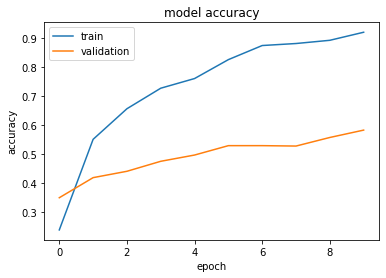

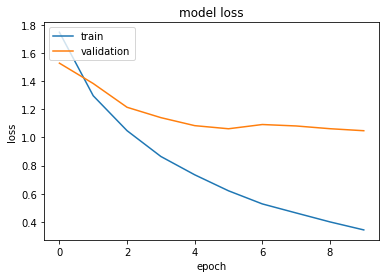

In [119]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

Видимо в связи с усложнением, модель ушла в жесткое переобучение. Конечно же, существует множество методов борьбы с переобучением: дропауты, нормализация, learning rate, размер бачей, размер и количество слоев, но у меня достаточно хорошо работает модель, основанная на  CNN с accuracy  больше 96% и при этом она гораздо легче. Поэтому, если не требуется жутко высокая точность, лучше довести до ума модель на CNN, чем  эту.